# Extreme value analysis on ERA5 data

In this notebook we demonstrate calculations of extreme value analysis for ERA5 variables. Similar analysis would be possible to other similar gridded reanalysis data sets. As ERA5 is quite a low resolution (0.25°) data set, extremes are bound to be smoothened. For more refined analysis, a higher resolution data could be used. For example ERA5 Land has 0.1° spatial resolution.

In [1]:
import warnings
import calendar
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)

Here we assume that we have precalculated monthly maxima of the ERA5 variables of interest.

In [2]:
era5 = xr.open_dataset('~/DATA/RISKADAPT/ERA5_Europe_monthly_max.nc')
era5

<xarray.Dataset>
Dimensions:    (time: 492, latitude: 187, longitude: 261)
Coordinates:
  * latitude   (latitude) float64 72.0 71.75 71.5 71.25 ... 26.0 25.75 25.5
  * longitude  (longitude) float64 -25.0 -24.75 -24.5 -24.25 ... 39.5 39.75 40.0
  * time       (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-12-31
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    ws10       (time, latitude, longitude) float32 ...
    tp24       (time, latitude, longitude) float32 ...

Plot the data at one selected lonlat point.

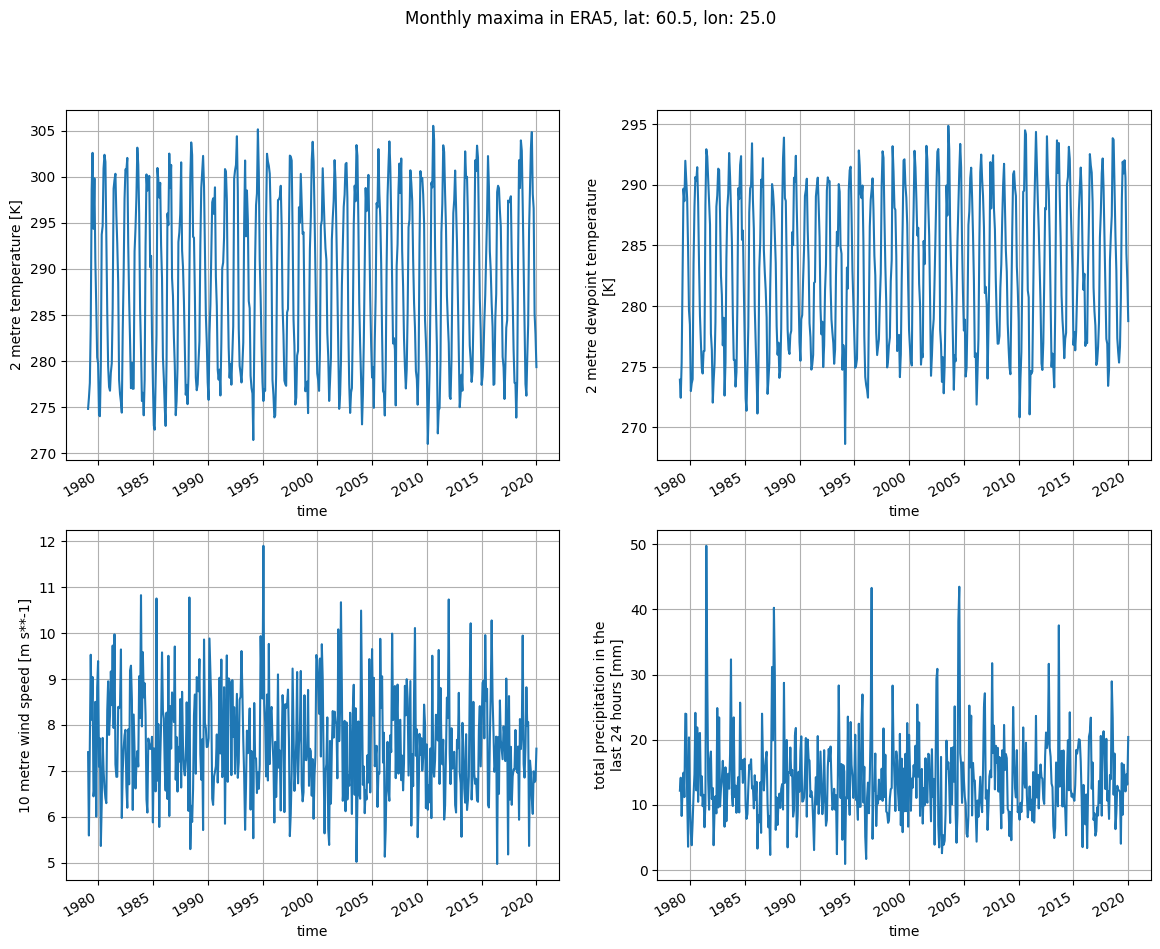

In [3]:
lon, lat = 25.0, 60.5

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
era5['t2m'].interp(latitude=lat, longitude=lon).plot(ax=axs[0,0])
era5['d2m'].interp(latitude=lat, longitude=lon).plot(ax=axs[0,1])
era5['ws10'].interp(latitude=lat, longitude=lon).plot(ax=axs[1,0])
era5['tp24'].interp(latitude=lat, longitude=lon).plot(ax=axs[1,1])
for ax in axs.ravel():
    ax.grid()
    ax.set_title('')
plt.suptitle(f'Monthly maxima in ERA5, lat: {lat}, lon: {lon}')
plt.show()

## GEV analysis

We provide a set of Python functions that to fit a generalized extreme value distribution to a time series data and calculate return levels for given return periods. It uses Stan probabilistic language to define the statistical model and calculate posterior probabilities for GEV parameters as well as for quantiles of the fitted distribution. These can be used to calculate return levels and their uncertainties. The estimation is based on Markov chain Monte Carlo (MCMC) sampling.

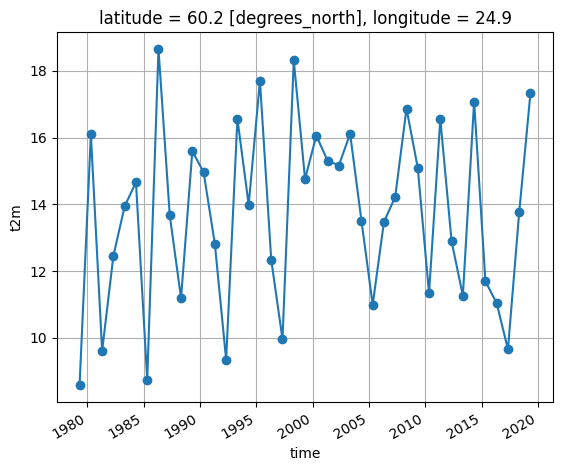

In [4]:
import cmdstan_gev as stangev

# select one location and one month
lat = 60.2
lon = 24.9
month = 4

months = era5['time.month']
y = era5['t2m'].where(months==month, drop=True).interp(latitude=lat, longitude=lon) - 273.15

y.plot(marker='o')
plt.grid()
plt.show()

In [5]:
fit = stangev.gev_fit(y, hyper={'xi0': -0.3, 'xisig0': 0.2, 'sig0': 3.5}, adapt_delta=0.85, show_progress=False)

13:35:33 - cmdstanpy - INFO - CmdStan start processing
13:35:33 - cmdstanpy - INFO - CmdStan start processing
13:35:33 - cmdstanpy - INFO - CmdStan done processing
13:35:33 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 157 divergent transitions (15.7%)
	Chain 2 had 148 divergent transitions (14.8%)
	Chain 3 had 208 divergent transitions (20.8%)
	Chain 4 had 154 divergent transitions (15.4%)
	Use function "diagnose()" to see further information.


Plot chain histograms of estimated GEV parameters.

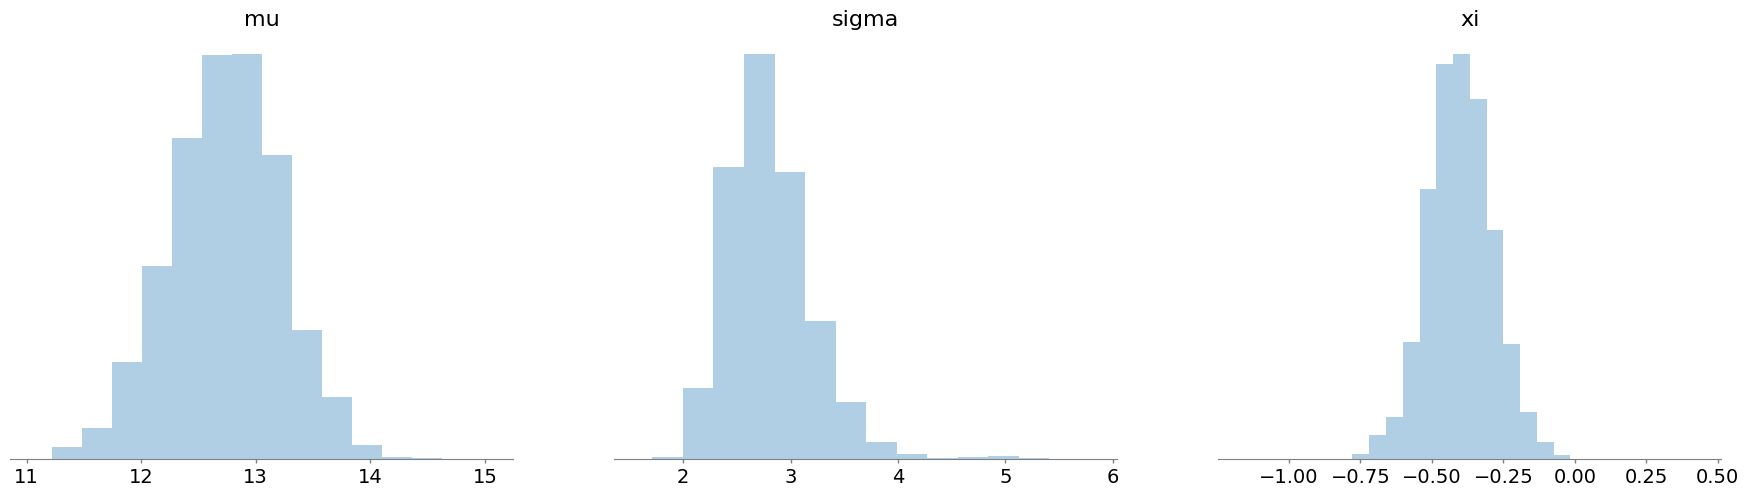

In [6]:
stangev.gev_posterior(fit)
plt.show()

Return level plot with return periods in logarithmic scale in the x axis. The blue shaded area gives 95% predictive uncertainty envelope for the return levels.

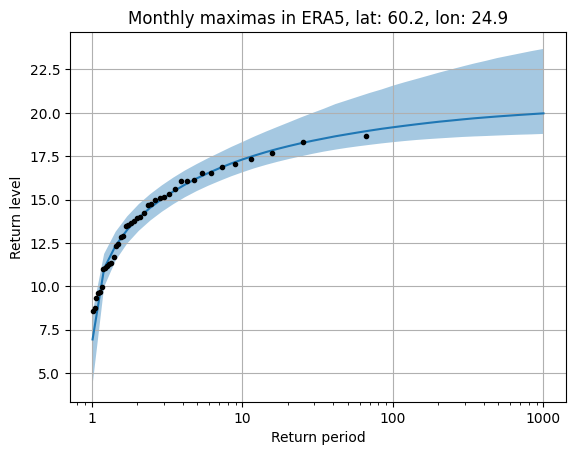

In [7]:
stangev.gev_qplot(y, fit, maxp=1000)
plt.title(f'Monthly maximas in ERA5, lat: {lat}, lon: {lon}')
plt.show()

## Analysis on selected coordinates

We can calculate selected return periods for any pixel or collection of pixels in the ERA5 data. Below we select some locations that are studied in RISKADAPT project. The same analyses will be extended to the future climate in the next phase.

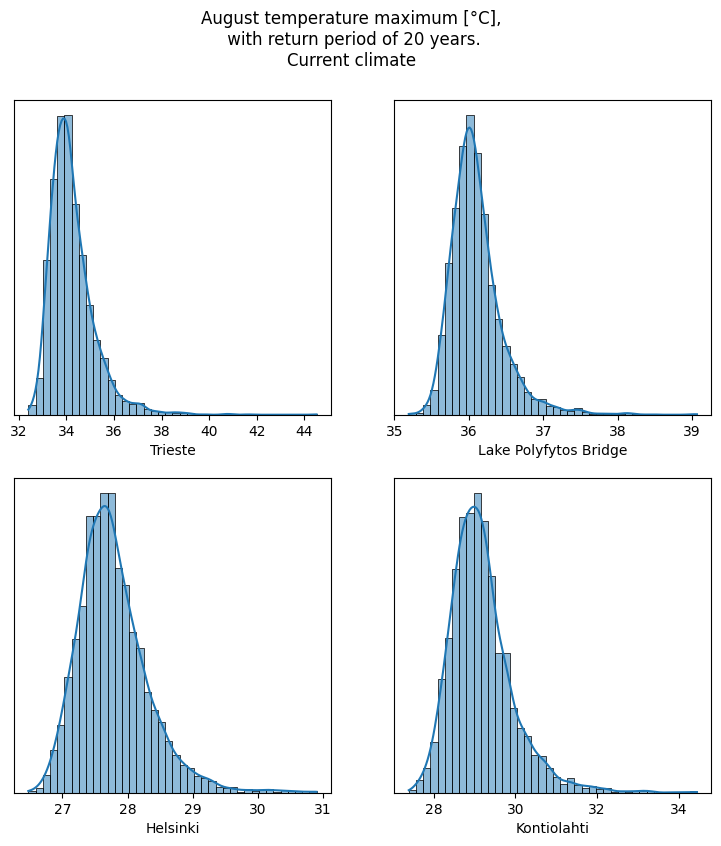

In [8]:
# lon, lat
locations = {
    'Trieste': [13.8, 45.63],
    'Lake Polyfytos Bridge': [21.973889, 40.232778],
    'Helsinki': [24.9375, 60.170833],
    'Kontiolahti': [30.0, 62.8],
}

return_periods = [20]
month = 8

fig, axs = plt.subplots(2,2, figsize=(9, 9))

for i, l in enumerate(locations):
    ax = axs.ravel()[i]
    lon, lat = locations[l]
    y = era5['t2m'].interp(latitude=lat, longitude=lon).where(era5['time.month']==month, drop=True) - 273.15
    fit = stangev.gev_fit(y, quiet=True, show_progress=False)
    rl_chain = stangev.gev_qpred(fit, yt = return_periods, return_chain=True)
    sns.histplot(rl_chain.values[:,0], bins=40, kde=True, stat='probability', ax=ax)
    ax.set_xlabel(f'{l}')
    ax.set_ylabel('')
    ax.set_yticks([])
plt.suptitle((f'{calendar.month_name[month]} temperature maximum [°C],'
              f'\n with return period of {return_periods[0]} years.'
              '\nCurrent climate'))
#axs[1,1].set_axis_off()
plt.show()


The plots above shows probability distributions of the estimated return levels of monthly maximum temperature in selected locations based on ERA5 monthly maxima. The figures show 20 year return period, so the estimated propability density for the maximum temperature to be observed at most every 20 years assuming the that climate stays the same as it has been during the years 1980-2019.